## Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam

### Data Overview

In [2]:
# Load the dataset
data = pd.read_csv('B2B_dataset.csv')

data.head()


,Product,Seller,Authority,Comp_size,Competitors,Purch_dept,Partnership,Budgt_alloc,Forml_tend,RFI,...,Source,Client,Scope,Strat_deal,Cross_sale,Up_sale,Deal_type,Needs_def,Att_t_client,Status
0,Product A,Seller 6,Mid,Mid,No,Unknown,No,Yes,No,Yes,...,Referral,Current,Clear,Very important,No,Yes,Project,Yes,Strategic account,Won
1,Product B,Seller 8,Mid,Big,No,Yes,No,Unknown,No,No,...,Referral,Current,Clear,Unimportant,No,Yes,Maintenance,Yes,Strategic account,Won
2,Product F,Seller 1,Mid,Big,No,No,Yes,No,No,No,...,Joint past,Current,Few questions,Average important,Yes,No,Project,Info gathering,Strategic account,Won
3,Product B,Seller 8,Mid,Big,No,Yes,No,No,No,No,...,Joint past,Current,Clear,Very important,No,Yes,Maintenance,Yes,Strategic account,Won
4,Product C,Seller 1,Mid,Small,Unknown,No,No,No,No,No,...,Unknown,New,Few questions,Average important,No,No,Project,No,Normal,Won


In [3]:

opportunity_condition = (
    data['Seller'].notnull() &  # Contacted by sales team
    data['Comp_size'].isin(['Mid', 'Big']) &  # Company size is Mid or Big
    data['Deal_type'].isin(['Solution', 'Project'])  # Deal type indicates opportunity
)

# Create a new binary target variable based on the condition
data['Opportunity'] = opportunity_condition.astype(int)

In [4]:
# Check the dimensions of the dataset
print("Dimensions of the dataset:", data.shape)

Dimensions of the dataset: (448, 24)


In [5]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

Missing values:
Product         0
Seller          0
Authority       0
Comp_size       0
Competitors     0
Purch_dept      0
Partnership     0
Budgt_alloc     0
Forml_tend      0
RFI             0
RFP             0
Growth          0
Posit_statm     0
Source          0
Client          0
Scope           0
Strat_deal      0
Cross_sale      0
Up_sale         0
Deal_type       0
Needs_def       0
Att_t_client    0
Status          0
Opportunity     0
dtype: int64


### Data Visualization

### Connecting to Datasource

In [6]:
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import IntegrityError
from models import ExecutionStatus, B2BSalesData, Base  # Import Base from models

def create_and_insert(engine, df):
    Session = sessionmaker(bind=engine)
    session = Session()
    
    try:
        # Create tables if not exists
        Base.metadata.create_all(engine)

        # Check if script has already been executed
        if not session.query(ExecutionStatus).filter_by(script_name='InsertValuesToB2BSaleData').first():
            # Insert data
            for _, row in df.iterrows():
                saleData_entry = B2BSalesData(**row.to_dict())
                session.add(saleData_entry)

            # Update execution status to indicate that insert statement has been executed
            session.add(ExecutionStatus(script_name='InsertValuesToB2BSaleData', executed=True))

            # Commit the changes
            session.commit()
            logging.info("Insert statement executed successfully")
        else:
            logging.info("Insert statement has already been executed before")
    except IntegrityError as e:
        session.rollback()
        logging.error("Error executing insert statement:", e)
    finally:
        session.close()

In [7]:
import json
import logging
from sqlalchemy import create_engine
from datetime import datetime

# Get current date and time
current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Configure logging with dynamic filename
log_filename = f"{current_time}.log"
logging.basicConfig(filename=log_filename, level=logging.INFO)

try:
    # Load connection details from the config file
    with open('config.json') as f:
        config = json.load(f)['mysql']

    # Create the database URL
    db_url = f"mysql+mysqlconnector://{config['user']}:{config['password']}@{config['host']}/{config['database']}"
    
    # Create the SQLAlchemy engine
    engine = create_engine(db_url)

    # Test the connection
    with engine.connect() as connection:
        logging.info("Connected to MySQL database successfully")
        create_and_insert(engine, data)
        
except Exception as e:
    logging.error("Failed to connect to MySQL database: %s", e)

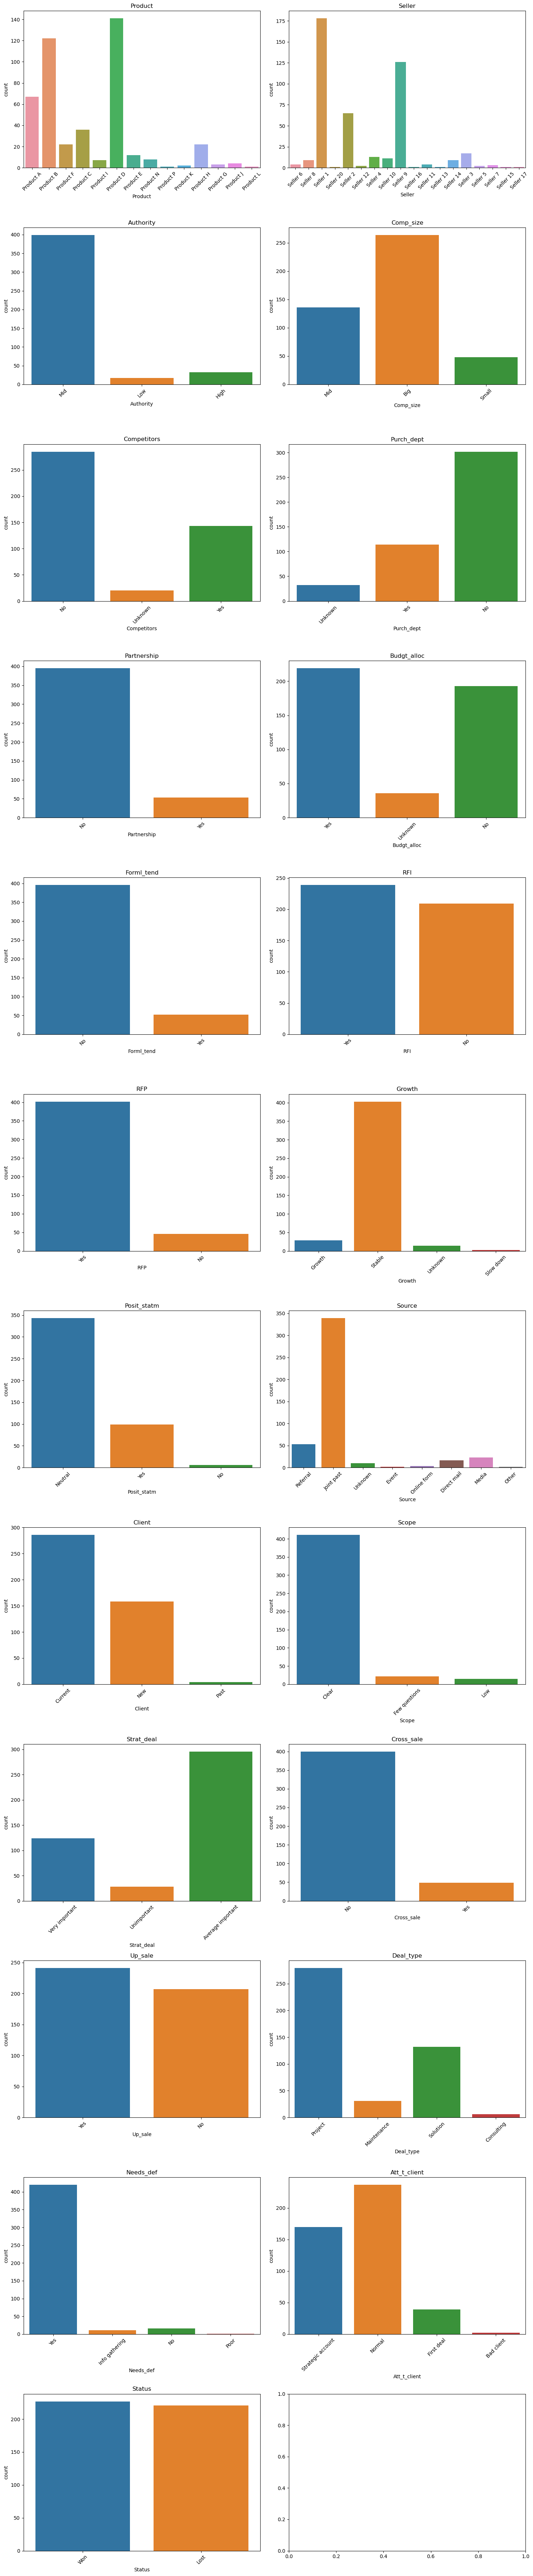

In [8]:
# Visualize the distribution of categorical features in two columns
categorical_features = data.select_dtypes(include=[object])
num_cols = len(categorical_features.columns)
num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed for two columns

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6*num_rows))

for i, column in enumerate(categorical_features.columns):
    row = i // 2
    col = i % 2
    sns.countplot(x=column, data=data, ax=axes[row, col])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)  # Rotate x-axis labels
    axes[row, col].set_title(column)

# Adjust layout
plt.tight_layout()
plt.show()


### Connect to Grafana Dashboard

In [9]:
import webbrowser

def launch_grafana_dashboard(dashboard_url):
    webbrowser.open(dashboard_url)

if __name__ == "__main__":
    
    # Load from Json
    
    # Load connection details from the config file
    with open('config.json') as f:
        grafana_config = json.load(f)['grafana']
        
    
    dashboard_url = f"{grafana_config['url']}/{grafana_config['dashboard_id']}/{grafana_config['dashboard_slug']}?orgId={grafana_config['org_id']}"
    launch_grafana_dashboard(dashboard_url)


## Preprocessing Step

### Remove unnecessary columns

In [10]:
data = data.drop(columns=['Product'])
data = data.drop(columns=['Seller'])

### Encoding Categorical Variables

In [11]:
# Convert categorical columns to categorical data type
categorical_columns = ['Authority', 'Comp_size', 'Competitors', 'Purch_dept', 'Partnership', 
                       'Budgt_alloc', 'Forml_tend', 'RFI', 'RFP', 'Growth', 'Posit_statm', 
                       'Client', 'Scope', 'Strat_deal', 'Cross_sale', 'Deal_type', 'Needs_def', 
                       'Att_t_client', 'Status', 'Source', 'Up_sale']

for col in categorical_columns:
    data[col] = data[col].astype('category')

# Convert categorical values to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
for col in categorical_columns:
    data[col] = label_encoder.fit_transform(data[col])


### Correlation

In [12]:
# Calculate the correlation matrix for the subset of data
correlation_matrix = data.corr()

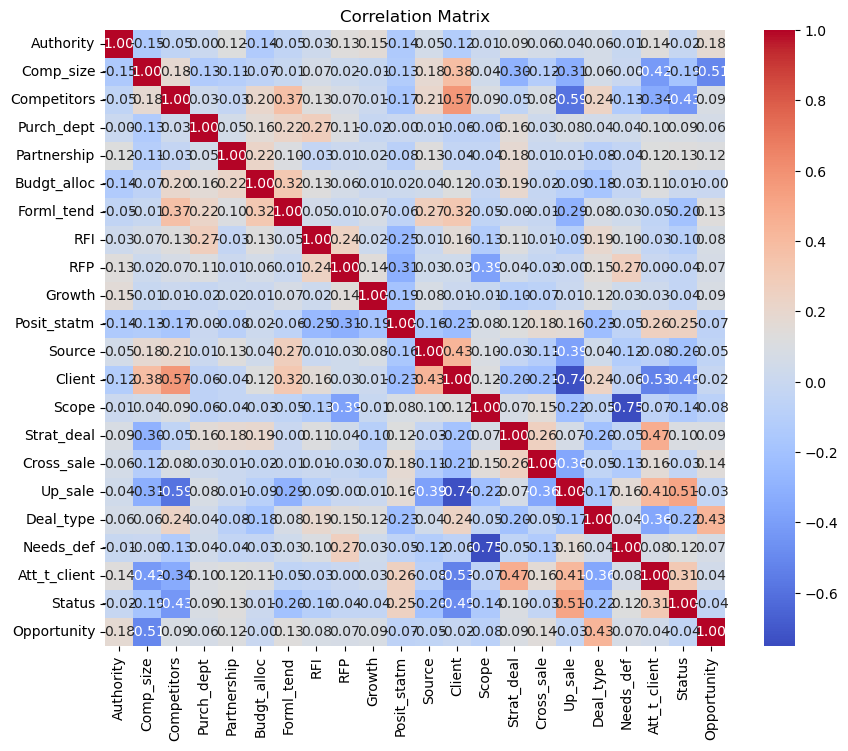

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the correlation matrix using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


### Splitting the Dataset

In [14]:
# Separate features (X) and target variable (y)
X = data.drop(columns=['Status'])  # Features
y = data['Status']  # Target variable

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [15]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_scale.npy', scaler.scale_)

### Predicition Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam as Adam_legacy
from sklearn.preprocessing import StandardScaler

# Define the model architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')
])

# Compile the model using legacy Adam optimizer
optimizer = Adam_legacy(learning_rate=0.001)  # Adjust learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Save the model
model.save('opportunity_to_sales_model.keras')


Epoch 1/50
9/9 [==============================] - 0s 9ms/step - loss: 0.7488 - accuracy: 0.5280 - val_loss: 0.6017 - val_accuracy: 0.7778
Epoch 2/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6785 - accuracy: 0.5874 - val_loss: 0.5560 - val_accuracy: 0.7917
Epoch 3/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6052 - accuracy: 0.6678 - val_loss: 0.5245 - val_accuracy: 0.8056
Epoch 4/50
9/9 [==============================] - 0s 2ms/step - loss: 0.6135 - accuracy: 0.6783 - val_loss: 0.5139 - val_accuracy: 0.8056
Epoch 5/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5772 - accuracy: 0.6993 - val_loss: 0.5149 - val_accuracy: 0.7778
Epoch 6/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5523 - accuracy: 0.7378 - val_loss: 0.5139 - val_accuracy: 0.7778
Epoch 7/50
9/9 [==============================] - 0s 2ms/step - loss: 0.5556 - accuracy: 0.7168 - val_loss: 0.5159 - val_accuracy: 0.7639
Epoch 8/50
9/9 [==================

### Model Evaluation

In [17]:
# Evaluate the model
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred.round())
print('Accuracy:', accuracy)


3/3 [==============================] - 0s 770us/step
Accuracy: 0.7666666666666667


In [18]:
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    # Convert probabilities to binary predictions
    y_pred_binary = y_pred.round()
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred_binary)
    
    # Calculate sensitivity (recall)
    sensitivity = recall_score(y_true, y_pred_binary)
    
    # Calculate specificity
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    
    # Calculate precision
    precision = precision_score(y_true, y_pred_binary)
    
    # Calculate F1-score
    f1 = f1_score(y_true, y_pred_binary)
    
    # Create a DataFrame to display the metrics
    metrics_table = pd.DataFrame({
        'Metric': ['Accuracy', 'Sensitivity (Recall)', 'Specificity', 'Precision', 'F1-score'],
        'Score': [accuracy, sensitivity, specificity, precision, f1]
    })
    
    return metrics_table

# Example usage
metrics_table = calculate_metrics(y_test, y_pred)
print(metrics_table)


                 Metric     Score
0              Accuracy  0.766667
1  Sensitivity (Recall)  0.847826
2           Specificity  0.681818
3             Precision  0.735849
4              F1-score  0.787879


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def create_confusion_matrix(y_test, y_pred):
    
    # Convert probabilities to binary predictions
    y_pred_binary = y_pred.round()

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred_binary)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    

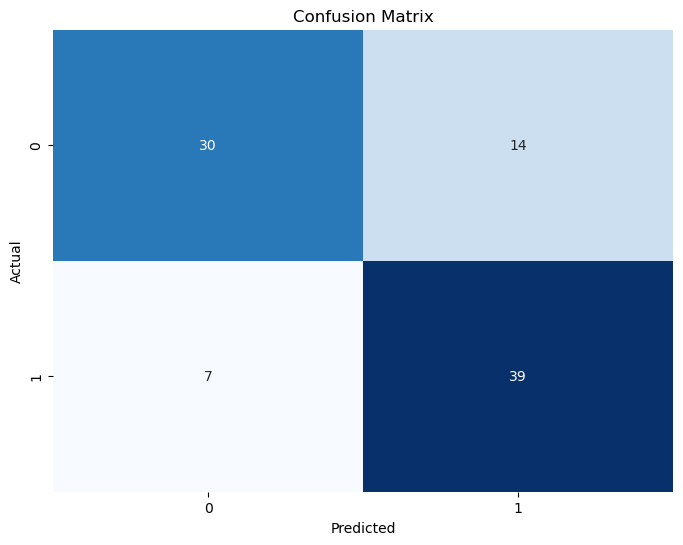

In [20]:
create_confusion_matrix(y_test, y_pred)

In [21]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Preprocess the data
X = data.drop('Opportunity', axis=1)  # Features
y = data['Opportunity']  # Target variable


In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

np.save('scaler_mean_1.npy', scaler.mean_)
np.save('scaler_scale_1.npy', scaler.scale_)


In [23]:
# Define the neural network architecture
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Save the model
model.save('Lead_to_Opportunity_model.keras')

Epoch 1/10
11/11 [==============================] - 0s 6ms/step - loss: 0.5837 - accuracy: 0.7578 - val_loss: 0.5292 - val_accuracy: 0.7778
Epoch 2/10
11/11 [==============================] - 0s 2ms/step - loss: 0.4760 - accuracy: 0.8292 - val_loss: 0.4853 - val_accuracy: 0.7778
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 0.4214 - accuracy: 0.8323 - val_loss: 0.4567 - val_accuracy: 0.7778
Epoch 4/10
11/11 [==============================] - 0s 2ms/step - loss: 0.3808 - accuracy: 0.8323 - val_loss: 0.4247 - val_accuracy: 0.7778
Epoch 5/10
11/11 [==============================] - 0s 2ms/step - loss: 0.3466 - accuracy: 0.8571 - val_loss: 0.3831 - val_accuracy: 0.7778
Epoch 6/10
11/11 [==============================] - 0s 2ms/step - loss: 0.3159 - accuracy: 0.8758 - val_loss: 0.3543 - val_accuracy: 0.7778
Epoch 7/10
11/11 [==============================] - 0s 2ms/step - loss: 0.2897 - accuracy: 0.8789 - val_loss: 0.3228 - val_accuracy: 0.8056
Epoch 8/10
11/11 [==

In [24]:
# Make predictions
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

3/3 [==============================] - 0s 1ms/step
Accuracy: 0.9


In [25]:
metrics_table = calculate_metrics(y_test, y_pred)
print(metrics_table)

                 Metric     Score
0              Accuracy  0.900000
1  Sensitivity (Recall)  1.000000
2           Specificity  0.470588
3             Precision  0.890244
4              F1-score  0.941935


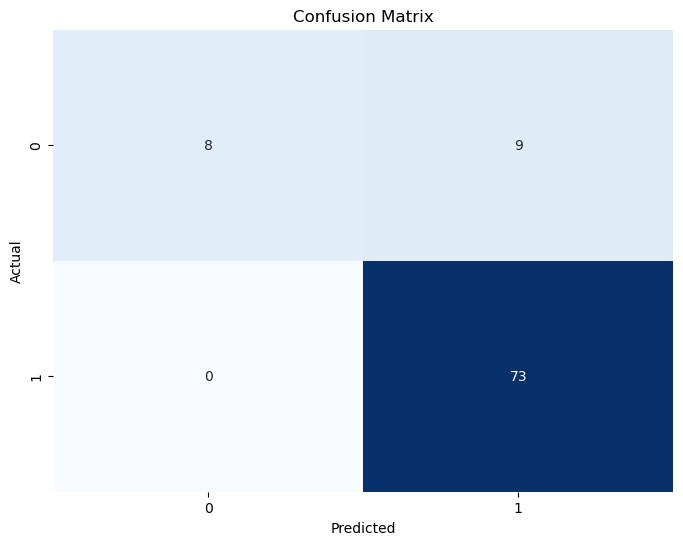

In [26]:
create_confusion_matrix(y_test, y_pred)